## 0. Package

In [1]:
import pandas as pd

from pipeline import dl, pp, cl, pl, utils
from collections import Counter

# hide warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto load change to package
%load_ext autoreload
%autoreload 2

## 1. Data Loading

__dataset__

In [2]:
dataset_path = pd.read_csv('dataset.txt', header = None, index_col=None)
dataset_path[0]

0    /projects/zhanglab/data/sc_data/TMS_2020/tabul...
1    /projects/zhanglab/data/sc_data/TMS_2020/tabul...
2    /projects/zhanglab/data/sc_data/TS_Science_202...
3    /projects/zhanglab/data/sc_data/TS_Science_202...
4    /projects/zhanglab/data/sc_data/nathan_2021/ra...
Name: 0, dtype: object

__load data__

In [3]:
file = dataset_path[0][0]

adata = dl.load_data(file)

load:  /projects/zhanglab/data/sc_data/TMS_2020/tabula-muris-senis-facs-official-raw-obj.h5ad
n_obs × n_vars:  (110824, 22966)
running time:  0.0001323223114013672


## 2. Data Pre-Processing

In [4]:
target = 'free_annotation'
# Counter(adata.obs[target])
k = 30

### 2.1 preprocessing

__min genes/cells & normalization__

In [5]:
adata = pp.preprocess(adata, min_genes = 500, min_cells = 2000, target_sum = 1e4)

n_obs × n_vars:  (110823, 14034)


__highly-variable genes__

In [6]:
adata = pp.hvg(adata)

n_obs × n_vars:  (110823, 2800)


### 2.2 Celltypes

__filter large clusters__

In [20]:
adata, celltypes = dl.filter_top_k_clusters(adata, target, k = k)
celltypes

#k: 30
#k: 30


Counter({'mesenchymal progenitor': 4733,
         'fibroblast of cardiac tissue': 3711,
         'granulocyte': 3123,
         'naïve B cell': 2959,
         'coronary vascular endothelial cell': 2718,
         'CD79a B cell': 2639,
         'Endothelial cell': 2190,
         'basal cell': 2029,
         'Capillary': 1790,
         'DN4 thymocyte': 1756,
         'Lgr5- amplifying undifferentiated cell': 1704,
         'outer bulge': 1555,
         'MPP Fraction B + C': 1297,
         'monocyte': 1281,
         'monocyte + promonocyte': 1015,
         'DN to DP transition (most are Cd8+/ Cd4+, some undergoing VDJ recombination)': 1001,
         'MPP Fraction A + HSC': 964,
         'MPP Fraction B': 942,
         'pre B cell': 856,
         'B cell': 654,
         'Lgr5+ undifferentiated cell (Distal)': 651,
         'proliferating thymocyte; DN to DP transition, dividing (some are Cd8+/ Cd4+, some undergoing VDJ recombination)': 624,
         'Enterocyte (Proximal)': 613,
         'ma

__encoding__

In [8]:
labels, labels_dict = dl.label_encode(adata, target)
labels_dict

/home/chunchua/ScClusterMetric/experiments/pipeline/dl.py:61: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['label'] = labels


{'pancreatic B cell': 0,
 'outer bulge': 1,
 'B cell': 2,
 'CD79a B cell': 3,
 'fibroblast of cardiac tissue': 4,
 'pancreatic acinar cell': 5,
 'coronary vascular endothelial cell': 6,
 'monocyte': 7,
 'proliferating thymocyte; DN to DP transition, dividing (some are Cd8+/ Cd4+, some undergoing VDJ recombination)': 8,
 'macrophage': 9,
 'Endothelial cell': 10,
 'bladder mesenchymal cell (Car3+)': 11,
 'Lgr5+ undifferentiated cell (Distal)': 12,
 'granulocyte': 13,
 'mesenchymal progenitor': 14,
 'Lgr5- amplifying undifferentiated cell': 15,
 'Reg4/cKit+ deep crypt secretory cells (Distal)': 16,
 'Enterocyte (Proximal)': 17,
 'Capillary': 18,
 'naïve B cell': 19,
 'immature B cell': 20,
 'pre B cell': 21,
 'monocyte + promonocyte': 22,
 'MPP Fraction B + C': 23,
 'MPP Fraction A + HSC': 24,
 'MPP Fraction B': 25,
 'DN4 thymocyte': 26,
 'DN to DP transition (most are Cd8+/ Cd4+, some undergoing VDJ recombination)': 27,
 'basal cell': 28,
 'luminal progenitor cell': 29}

## 3. Dimensionality Reduction

In [9]:
import scanpy as sc
data = sc.pp.subsample(adata, fraction = 0.01, copy = True, random_state = 42) 

### PCoA

dm: (448, 448), running time: 0.1149907112121582
pcoa: (448, 50), running time: 0.0377039909362793


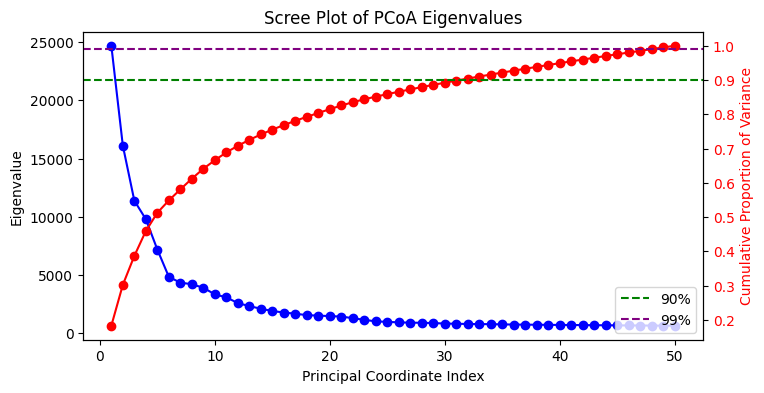

In [10]:
metric = 'l2'
data = cl.compute_distance_matrix(data, 'l2', True)
data = cl.compute_pcoa(data, 'l2', 50, verbose = True)

pl.plot_scree(data.uns['pcoa']['l2_eigvals'])

### PCA

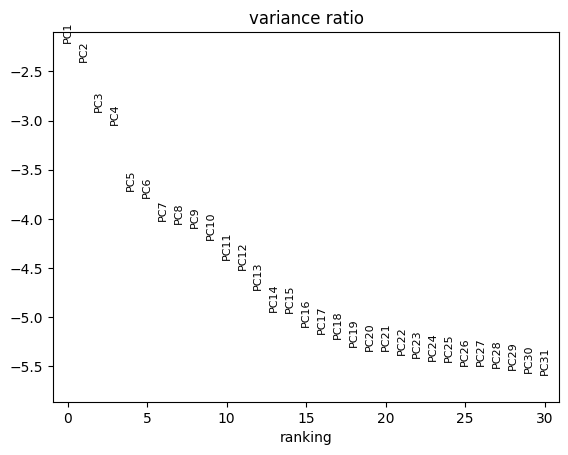

In [244]:
sc.tl.pca(data, svd_solver="arpack")
sc.pl.pca_variance_ratio(data, log=True)

### run/save all metric for experiement

In [46]:
data = sc.pp.subsample(adata, n_obs = 30000, copy = True, random_state = 42)
data

AnnData object with n_obs × n_vars = 30000 × 2800
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [11]:
# pcoa
for metric in ['l1','l2','cosine','correlation']:
    print(f'[{metric}]')
    data = cl.compute_distance_matrix(data, metric, verbose = True)
    data = cl.compute_pcoa(data, metric, 50, verbose = True)

# pca
sc.tl.pca(data, svd_solver="arpack")

data.write('/projects/zhanglab/users/david/data/TMS_fasq_300K.h5ad')

[l1]
dm: (448, 448), running time: 0.24784541130065918
pcoa: (448, 50), running time: 0.04351472854614258
[l2]
dm: (448, 448), running time: 0.13259029388427734
pcoa: (448, 50), running time: 0.030319929122924805
[cosine]
dm: (448, 448), running time: 0.23345613479614258
pcoa: (448, 50), running time: 0.04003024101257324
[correlation]
dm: (448, 448), running time: 0.24038219451904297
pcoa: (448, 50), running time: 0.041905879974365234


## 4. Clustering

### KNN + Leiden

In [17]:
for rd_metric in ['pca', 'l1','l2','cosine','correlation']:
    for alg_metric in ['l1','l2','cosine','correlation']:
        data = cl.compute_KNN(data, rd_metric, alg_metric)
        data = cl.compute_leiden(data, 1, rd_metric, alg_metric)

### evaluate

In [13]:
data

AnnData object with n_obs × n_vars = 448 × 2800
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label', 'leiden_pca_l1', 'leiden_pca_l2', 'leiden_pca_cosine', 'leiden_pca_correlation', 'leiden_l1_l1', 'leiden_l1_l2', 'leiden_l1_cosine', 'leiden_l1_correlation', 'leiden_l2_l1', 'leiden_l2_l2', 'leiden_l2_cosine', 'leiden_l2_correlation', 'leiden_cosine_l1', 'leiden_cosine_l2', 'leiden_cosine_cosine', 'leiden_cosine_correlation', 'leiden_correlation_l1', 'leiden_correlation_l2', 'leiden_correlation_cosine', 'leiden_correlation_correlation'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'time', 'pcoa', 'pca', 'KNN_l1', 'leiden', 'KNN_l2', 'KNN_cos

In [30]:
res = pd.DataFrame(columns=['dataset', 'algorithm', 'rd_metric', 'alg_metric', 'NMI', 'ARI', 'FM', 'Jaccard', '#k', 'write'])
write_path = '/projects/zhanglab/users/david/data/TMS_fasq_300K.h5ad'

In [31]:
import time
for rd_metric in ['pca', 'l1','l2','cosine','correlation']:
    for alg_metric in ['l1','l2','cosine','correlation']:

        start_time = time.time()
                
        # data = cl.compute_KNN(data, rd_metric, alg_metric)
        # data = cl.compute_leiden(data, 1, rd_metric, alg_metric)

        entry = utils.get_stats(data, target, rd_metric, alg_metric, write_path)
        
        res.loc[len(res.index)] = entry.values() 

        print(f"RD: {rd_metric[:3]:>3}, AL: {alg_metric[:3]:>3} {time.time()-start_time:.2f} seconds")
        
        # res.to_csv('results_051324.csv', index=False)


RD: pca, AL:  l1 0.01 seconds
RD: pca, AL:  l2 0.01 seconds
RD: pca, AL: cos 0.01 seconds
RD: pca, AL: cor 0.01 seconds
RD:  l1, AL:  l1 0.01 seconds
RD:  l1, AL:  l2 0.01 seconds
RD:  l1, AL: cos 0.01 seconds
RD:  l1, AL: cor 0.01 seconds
RD:  l2, AL:  l1 0.01 seconds
RD:  l2, AL:  l2 0.01 seconds
RD:  l2, AL: cos 0.01 seconds
RD:  l2, AL: cor 0.01 seconds
RD: cos, AL:  l1 0.01 seconds
RD: cos, AL:  l2 0.01 seconds
RD: cos, AL: cos 0.01 seconds
RD: cos, AL: cor 0.01 seconds
RD: cor, AL:  l1 0.01 seconds
RD: cor, AL:  l2 0.01 seconds
RD: cor, AL: cos 0.01 seconds
RD: cor, AL: cor 0.01 seconds


In [32]:
res

,dataset,algorithm,rd_metric,alg_metric,NMI,ARI,FM,Jaccard,#k,write
0,TS_fasq,leiden,pca,l1,0.904667,0.796237,0.816982,0.0,19,/projects/zhanglab/users/david/data/TMS_fasq_3...
1,TS_fasq,leiden,pca,l2,0.904585,0.795864,0.816676,0.0,19,/projects/zhanglab/users/david/data/TMS_fasq_3...
2,TS_fasq,leiden,pca,cosine,0.913352,0.804618,0.825129,0.0,19,/projects/zhanglab/users/david/data/TMS_fasq_3...
3,TS_fasq,leiden,pca,correlation,0.913352,0.804618,0.825129,0.0,19,/projects/zhanglab/users/david/data/TMS_fasq_3...
4,TS_fasq,leiden,l1,l1,0.893142,0.747174,0.777012,0.0,17,/projects/zhanglab/users/david/data/TMS_fasq_3...
5,TS_fasq,leiden,l1,l2,0.901321,0.766069,0.793275,0.0,18,/projects/zhanglab/users/david/data/TMS_fasq_3...
6,TS_fasq,leiden,l1,cosine,0.907928,0.795824,0.817935,0.0,18,/projects/zhanglab/users/david/data/TMS_fasq_3...
7,TS_fasq,leiden,l1,correlation,0.907928,0.795824,0.817935,0.0,18,/projects/zhanglab/users/david/data/TMS_fasq_3...
8,TS_fasq,leiden,l2,l1,0.904667,0.796237,0.816982,0.0,19,/projects/zhanglab/users/david/data/TMS_fasq_3...
9,TS_fasq,leiden,l2,l2,0.904585,0.795864,0.816676,0.0,19,/projects/zhanglab/users/david/data/TMS_fasq_3...
